在这个notebook中，启用了GPU和 Internet access(这是预先训练参数所需要的)。由于预测过程不能使用Internet，所以在[另一个notebook](https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-inference)进行。

    FasterRCNN from torchvision
    Use Resnet50 backbone
    Albumentation enabled (simple flip for now)


In [4]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

DIR_INPUT = './dataset/global-wheat-detection'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

In [5]:
train_df = pd.read_csv(f'{DIR_INPUT}/train.csv')
train_df.shape

(147793, 5)

In [6]:
train_df

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1
...,...,...,...,...,...
147788,5e0747034,1024,1024,"[64.0, 619.0, 84.0, 95.0]",arvalis_2
147789,5e0747034,1024,1024,"[292.0, 549.0, 107.0, 82.0]",arvalis_2
147790,5e0747034,1024,1024,"[134.0, 228.0, 141.0, 71.0]",arvalis_2
147791,5e0747034,1024,1024,"[430.0, 13.0, 184.0, 79.0]",arvalis_2


In [7]:
# 添加四列用于分别保存坐标信息，初始化为-1
train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)#删除‘bbox'这一列
train_df['x'] = train_df['x'].astype(np.float)
train_df['y'] = train_df['y'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)

In [8]:
train_df

,image_id,width,height,source,x,y,w,h
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024,1024,usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024,1024,usask_1,26.0,144.0,124.0,117.0
...,...,...,...,...,...,...,...,...
147788,5e0747034,1024,1024,arvalis_2,64.0,619.0,84.0,95.0
147789,5e0747034,1024,1024,arvalis_2,292.0,549.0,107.0,82.0
147790,5e0747034,1024,1024,arvalis_2,134.0,228.0,141.0,71.0
147791,5e0747034,1024,1024,arvalis_2,430.0,13.0,184.0,79.0


In [9]:
image_ids = train_df['image_id'].unique()
valid_ids = image_ids[-665:]
train_ids = image_ids[:-665]

In [10]:
valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]

In [11]:
valid_df.shape, train_df.shape

((25006, 8), (122787, 8))

In [12]:
class WheatDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [13]:
# Albumentations
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

## Create the model

In [14]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)


In [15]:
num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [16]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0


In [17]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = WheatDataset(train_df, DIR_TRAIN, get_train_transform())
valid_dataset = WheatDataset(valid_df, DIR_TRAIN, get_valid_transform())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)


In [18]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Sample

In [19]:
images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [20]:
boxes = targets[2]['boxes'].cpu().numpy().astype(np.int32)
sample = images[2].permute(1,2,0).cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


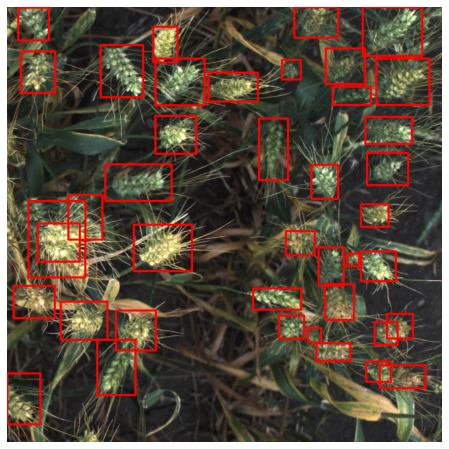

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

## Train

In [22]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

num_epochs = 10

In [23]:
loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}") 

In [24]:
images, targets, image_ids = next(iter(valid_data_loader))

In [25]:
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]


In [26]:
boxes = targets[1]['boxes'].cpu().numpy().astype(np.int32)
sample = images[1].permute(1,2,0).cpu().numpy()


In [27]:
model.eval()
cpu_device = torch.device("cpu")

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


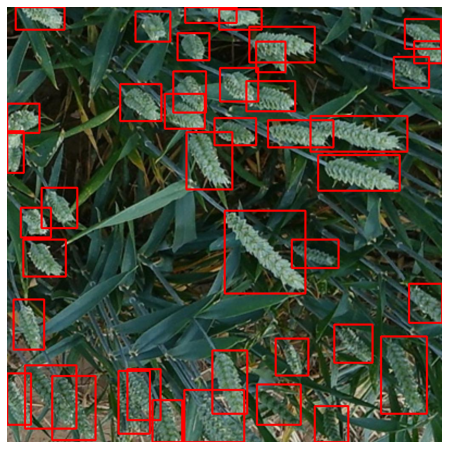

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)



In [29]:
torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')